In [1]:
import os
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from utl2 import dataset, ToTensor
from cnn_mlp import CNN_MLP
from cnn_lstm import CNN_LSTM
from resnet18 import Resnet18_MLP
from cnn_logical_v1_multiple_components_in_choice import CNN_Logical

In [12]:
class args():
    model='CNN_Logical'
    epochs=200
    batch_size=32
    seed=12345
    dataset = 'iRaven'
    device = 3
    load_workers = 16
    resume = False
    path = "/common/users/pv217/raven_dataset/RAVEN-10000"
    save = "/common/users/pv217/model_checkpoints/full_cnn_logical_multiple_eval_raven/"
    img_size = 80
    lr = 1e-4
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    meta_alpha = 0.0
    meta_beta = 0.0
    cuda = torch.cuda.is_available()    

In [13]:
args.cuda = torch.cuda.is_available()
torch.cuda.set_device(args.device)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [14]:
data_path = args.path

In [15]:
train = dataset(data_path, "train", args.img_size, transform=transforms.Compose([ToTensor()]),shuffle=True,
                rotate=False,vertical_flip=True, vertical_roll = False,
                horizontal_flip = True, horizontal_roll= False, max_rotate_angle = 180
               )
valid = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
test = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))

In [16]:
trainloader = DataLoader(train, batch_size=args.batch_size, shuffle=True, num_workers=16)
validloader = DataLoader(valid, batch_size=args.batch_size, shuffle=False, num_workers=16)
testloader = DataLoader(test, batch_size=args.batch_size, shuffle=False, num_workers=16)

In [17]:
train.__getitem__(1)[2].shape

torch.Size([9])

In [18]:
train.__getitem__(1)[2].sum()

tensor(9.)

In [19]:
if args.model == "CNN_MLP":
    model = CNN_MLP(args)
elif args.model == "CNN_LSTM":
    model = CNN_LSTM(args)
elif args.model == "Resnet18_MLP":
    model = Resnet18_MLP(args)
elif args.model == "CNN_Logical":
    model = CNN_Logical(args)

In [20]:
if args.resume:
    model.load_model(args.save, 0)
    print('Loaded model')
if args.cuda:
    model = model.cuda()

In [21]:
def train(epoch):
    model.train()
    train_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(trainloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        loss, acc = model.train_(image, target, meta_target)
        #print('Train: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc))
        loss_all += loss
        acc_all += acc
    print(epoch)
    if counter > 0:
        print("Avg Training Loss: {:.6f}".format(loss_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)


In [22]:
def validate(epoch):
    model.eval()
    val_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(validloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        loss, acc = model.validate_(image, target, meta_target)
        # print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
    if counter > 0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)

In [23]:
def test(epoch):
    model.eval()
    accuracy = 0

    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(testloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)

In [ ]:
epoch_lst = []
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
test_acc_lst = []

for epoch in range(0, args.epochs):
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validate(epoch)
    test_acc = test(epoch)
    epoch_lst.append(epoch)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)
    model.save_model(args.save, epoch, val_acc, val_loss)
    
    

0
Avg Training Loss: 2.553242
Total Validation Loss: 2.317221, Acc: 5.7506
Total Testing Acc: 5.9646
1
Avg Training Loss: 2.307419
Total Validation Loss: 2.209967, Acc: 5.7078
Total Testing Acc: 5.5579
2
Avg Training Loss: 2.213789
Total Validation Loss: 2.175650, Acc: 5.4723
Total Testing Acc: 5.6792
3
Avg Training Loss: 2.178676
Total Validation Loss: 2.131681, Acc: 8.2192
Total Testing Acc: 8.4332
4
Avg Training Loss: 2.142423
Total Validation Loss: 2.095517, Acc: 9.6889
Total Testing Acc: 9.8816
5
Avg Training Loss: 2.112779
Total Validation Loss: 2.079269, Acc: 9.8744
Total Testing Acc: 10.2454
6
Avg Training Loss: 2.090649
Total Validation Loss: 2.052957, Acc: 11.0945
Total Testing Acc: 11.1587
7
Avg Training Loss: 2.073419
Total Validation Loss: 2.047175, Acc: 11.3941
Total Testing Acc: 11.6153
8
Avg Training Loss: 2.060710
Total Validation Loss: 2.022776, Acc: 12.3216
Total Testing Acc: 12.3359
9
Avg Training Loss: 2.047579
Total Validation Loss: 2.010754, Acc: 12.3216
Total Te

In [25]:
import pandas as pd
import seaborn as sns

In [26]:
training_stats = pd.DataFrame({'epoch':epoch_lst,
 'training_loss':train_loss_lst,
 'training_accuracy':train_acc_lst,
 'validation_loss':val_loss_lst,
 'validation_accuracy':val_acc_lst,
 'test_accuracy':test_acc_lst
})

In [27]:
training_stats = training_stats.set_index('epoch')

In [28]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:xlabel='epoch'>

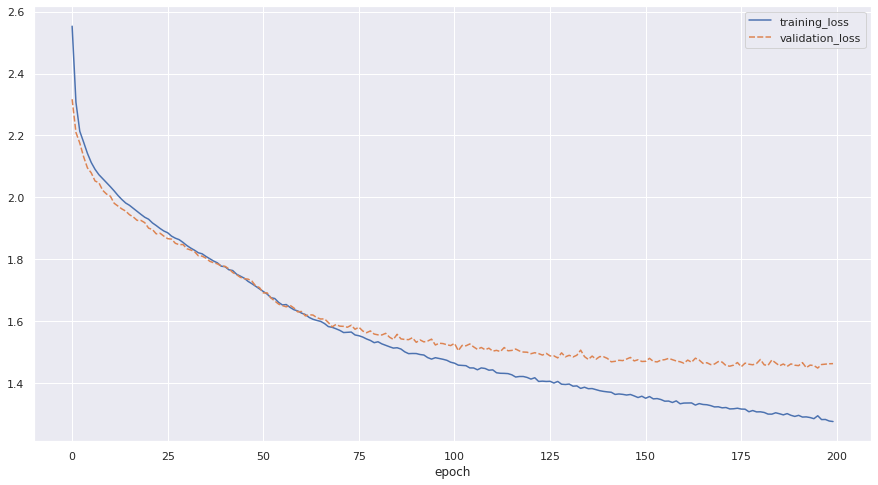

In [29]:
sns.lineplot(data=training_stats[['training_loss','validation_loss']])

<AxesSubplot:xlabel='epoch'>

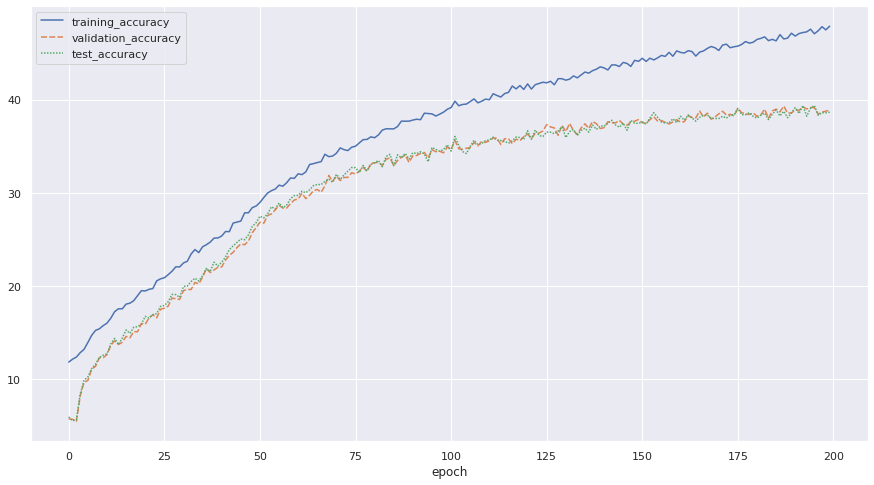

In [30]:
sns.lineplot(data=training_stats[['training_accuracy','validation_accuracy','test_accuracy']])

#### Checking Model performance on each configuration  

In [31]:
def validate():
    model.eval()
    val_loss = 0
    accuracy = 0
    epoch = 1
    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(validloader):
        counter += 1
#         print(counter)
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
        loss, acc = model.validate_(image, target, meta_target)
#         print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
#         print(counter)
    if counter >0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return  acc_all/float(counter)

def test():
    model.eval()
    accuracy = 0
    epoch = 1
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(testloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)

In [32]:
config_lst = []
config_val_acc_list = []
config_test_acc_list = []
for i in ['/center_single/','/distribute_four/','/distribute_nine/',
          '/in_center_single_out_center_single/','/in_distribute_four_out_center_single/', 
          '/left_center_single_right_center_single/','/up_center_single_down_center_single/']:
    valid_dt = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    config_lst.append(i[1:-1])
    config_val_acc_list.append(validate())
    config_test_acc_list.append(test())
    
    

Total Validation Loss: 1.142376, Acc: 58.4325
Total Testing Acc: 62.5496
Total Validation Loss: 1.345509, Acc: 45.6845
Total Testing Acc: 45.0397
Total Validation Loss: 1.422950, Acc: 47.2222
Total Testing Acc: 43.4524
Total Validation Loss: 1.438890, Acc: 35.8135
Total Testing Acc: 39.1369
Total Validation Loss: 1.377621, Acc: 40.6746
Total Testing Acc: 39.0377
Total Validation Loss: 1.754306, Acc: 22.6190
Total Testing Acc: 21.0813
Total Validation Loss: 1.756514, Acc: 21.4286
Total Testing Acc: 20.8829


In [33]:
pd.DataFrame({'configuration':config_lst,'validation_accuracy':config_val_acc_list, 'test_accuracy':config_test_acc_list})

,configuration,validation_accuracy,test_accuracy
0,center_single,58.432540,62.549603
1,distribute_four,45.684524,45.039683
2,distribute_nine,47.222222,43.452381
3,in_center_single_out_center_single,35.813492,39.136905
4,in_distribute_four_out_center_single,40.674603,39.037698
5,left_center_single_right_center_single,22.619048,21.081349
6,up_center_single_down_center_single,21.428571,20.882937


<AxesSubplot:xlabel='configuration', ylabel='test_accuracy'>

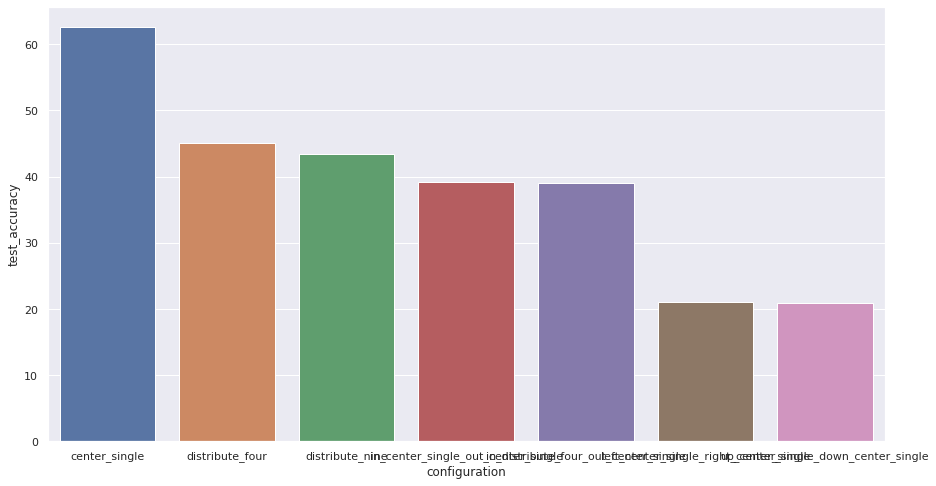

In [34]:
sns.barplot(x="configuration", y="test_accuracy", data=pd.DataFrame({'configuration':config_lst,'validation_accuracy':config_val_acc_list, 'test_accuracy':config_test_acc_list}))

In [35]:
# sns.s pd.DataFrame({'configuration':config_lst,'validation_accuracy':config_val_acc_list, 'test_accuracy':config_test_acc_list}).set_index('configuration')

In [48]:
for i in ['/center_single/','/distribute_four/','/in_distribute_four_out_center_single/', '/left_center_single_right_center_single/']:
    train_dt = dataset(data_path, "train", args.img_size, transform=transforms.Compose([ToTensor()]))
    valid_dt = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    train_dt.file_names = [x for x in train_dt.file_names if i in x]
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    print(i,len(set(train_dt.file_names)),len(set(valid_dt.file_names)),len(set(test_dt.file_names)))


/center_single/ 6000 2000 2000
/distribute_four/ 6000 2000 2000
/in_distribute_four_out_center_single/ 6000 2000 2000
/left_center_single_right_center_single/ 6000 2000 2000


In [37]:
training_stats.tail(20)

,training_loss,training_accuracy,validation_loss,validation_accuracy,test_accuracy
epoch,,,,,
180,1.307108,46.458492,1.476132,38.213470,38.027968
181,1.304968,46.570354,1.458903,38.370434,38.334760
182,1.299724,46.736957,1.457225,38.976884,38.563071
183,1.299550,46.332350,1.474550,38.013699,37.863870
184,1.303974,46.468012,1.464976,38.791381,38.427511
185,1.300818,46.308549,1.455832,38.984018,38.891267
186,1.297207,46.974962,1.461604,38.691495,38.256279
187,1.301244,46.508473,1.453776,39.305080,38.748573
188,1.295780,46.601295,1.461973,38.563071,38.063642


In [ ]:
from utl2 import dataset, ToTensor

In [63]:
# data_path_t = '/common/home/pv217/Downloads/Data-Color/'
test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]),matrix=True)

test_dt.file_names = [x for x in test_dt.file_names if '/center_single/' in x]
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)


In [64]:
def test_ra_pairs_(model, image, target, ra_pair_matrix):
        with torch.no_grad():
            output = model(image)
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        ra_pair_matrix_correct = pred.eq(target.data).cpu().numpy().reshape(-1,1,1)*ra_pair_matrix.numpy()
        accuracy = correct * 100.0 / target.size()[0]
        return accuracy, ra_pair_matrix_correct.sum(axis=0)

In [65]:
def test_ra_pairs():
#     model.eval()
    accuracy = 0
    epoch = 1
    acc_all = 0.0
    counter = 0
    data_ra_pairs = np.zeros((4,5))
    target_ra_pairs = np.zeros((4,5))
    for batch_idx, (image, target, meta_target,rule_attribute_matrix) in enumerate(testloader):
#         print(rule_attribute_matrix[10])
#         a = meta_matrix
        counter += 1
        data_ra_pairs += rule_attribute_matrix.sum(axis=0).numpy()
        
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        
        acc,acc_ra_pairs = test_ra_pairs_(model,image, target, rule_attribute_matrix)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        target_ra_pairs +=acc_ra_pairs
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
#     return rule_attribute_matrix
    return acc_all/float(counter),data_ra_pairs,target_ra_pairs

In [66]:
acc, data_ra_matrix, accurate_ra_matrix = test_ra_pairs()

Total Testing Acc: 72.3710


In [67]:
accurate_ra_matrix

array([[1447., 1447.,  506.,  470.,  385.],
       [   0.,    0.,  512.,  368.,  360.],
       [   0.,    0.,    0.,  256.,  366.],
       [   0.,    0.,  429.,  353.,  336.]])

In [68]:
data_ra_matrix

array([[2000., 2000.,  625.,  536.,  502.],
       [   0.,    0.,  696.,  456.,  484.],
       [   0.,    0.,    0.,  522.,  516.],
       [   0.,    0.,  679.,  486.,  498.]])

In [69]:
from matplotlib import pyplot as plt

/tmp/ipykernel_1641419/2072020424.py:3: RuntimeWarning: invalid value encountered in true_divide
  accuracy = accurate_ra_matrix/data_ra_matrix


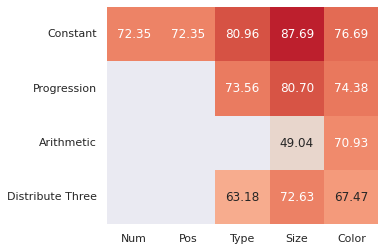

In [70]:
import seaborn as sns
%matplotlib inline
accuracy = accurate_ra_matrix/data_ra_matrix
Mask = np.zeros(np.shape(accuracy))
Mask[accuracy<=0.01] = 1
_accuracy = accuracy*100.0
midpoint = (_accuracy.max() - _accuracy.min()) / 2
# plot the heatmap
# plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(1)
sns.heatmap(_accuracy, 
            mask=Mask,
            vmin=0.0, vmax=90.0,
            #center = 45.0,
            cmap="coolwarm",
            square=True,
            robust=True,
            annot=True, fmt=".2f",annot_kws={'size':12},
            cbar=False,
        yticklabels=['Constant', 'Progression', 'Arithmetic', 'Distribute Three'],
        xticklabels=['Num', 'Pos', 'Type', 'Size', 'Color'])
# plt.xlabel('Attributes', fontsize=16)
# plt.ylabel('Rules', fontsize=16)
plt.savefig(f"heatmap_centersingle_i-raven.pdf", bbox_inches='tight', pad_inches=0)
# plt.text(5,12.3, "I-RAVEN", fontsize = 95, color='Black', fontstyle='italic')


In [71]:
# data_path_t = '/common/home/pv217/Downloads/Data-Color/'
test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]),matrix=True)

# test_dt.file_names = [x for x in test_dt.file_names if '/center_single/' in x]
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)


In [72]:
acc, data_ra_matrix, accurate_ra_matrix = test_ra_pairs()

Total Testing Acc: 47.6527


/tmp/ipykernel_1641419/405861729.py:3: RuntimeWarning: invalid value encountered in true_divide
  accuracy = accurate_ra_matrix/data_ra_matrix


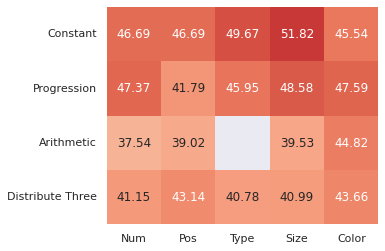

In [75]:
import seaborn as sns
%matplotlib inline
accuracy = accurate_ra_matrix/data_ra_matrix
Mask = np.zeros(np.shape(accuracy))
Mask[accuracy<=0.01] = 1
_accuracy = accuracy*100.0
midpoint = (_accuracy.max() - _accuracy.min()) / 2
# plot the heatmap
# plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(1)
sns.heatmap(_accuracy, 
            mask=Mask,
            vmin=0.0, vmax=55.0,
            #center = 45.0,
            cmap="coolwarm",
            square=True,
            robust=True,
            annot=True, fmt=".2f",annot_kws={'size':12},
            cbar=False,
        yticklabels=['Constant', 'Progression', 'Arithmetic', 'Distribute Three'],
        xticklabels=['Num', 'Pos', 'Type', 'Size', 'Color'])
# plt.xlabel('Attributes', fontsize=16)
# plt.ylabel('Rules', fontsize=16)
plt.savefig(f"heatmap_i-raven.pdf", bbox_inches='tight', pad_inches=0)
# plt.text(5,12.3, "I-RAVEN", fontsize = 95, color='Black', fontstyle='italic')


In [252]:
# Constant, Progression, Arithmetic,
# and Distribute Three


# Scene, Structure, Component,
# Layout, and Entity

In [49]:
data_path_t = '/common/home/pv217/Downloads/Data-Color/'
valid_dt = dataset(data_path_t, "val", args.img_size,\
                   transform=transforms.Compose([ToTensor()]))
test_dt = dataset(data_path_t, "test", args.img_size, \
                  transform=transforms.Compose([ToTensor()]))
print(len(valid_dt.file_names),len(test_dt.file_names))
validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
validate()
test()

1200 1200
Total Validation Loss: 0.629885, Acc: 78.1250
Total Testing Acc: 77.6316


77.63157894736842

In [46]:
data_path_t = '/common/home/pv217/Downloads/Data-Type/'
valid_dt = dataset(data_path_t, "val", args.img_size,\
                   transform=transforms.Compose([ToTensor()]))
test_dt = dataset(data_path_t, "test", args.img_size, \
                  transform=transforms.Compose([ToTensor()]))
validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
validate()
test()

Total Validation Loss: 0.789215, Acc: 67.7288
Total Testing Acc: 69.7304


69.73039215686275

In [47]:
data_path_t = '/common/home/pv217/Downloads/Data-Size//'
valid_dt = dataset(data_path_t, "val", args.img_size,\
                   transform=transforms.Compose([ToTensor()]))
test_dt = dataset(data_path_t, "test", args.img_size, \
                  transform=transforms.Compose([ToTensor()]))
validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
validate()
test()

Total Validation Loss: 0.945467, Acc: 62.0098
Total Testing Acc: 62.3775


62.377450980392155

In [52]:
data_path_t = '/common/home/pv217/Downloads/Data-Type/'

In [53]:
config_lst = []
config_val_acc_list = []
config_test_acc_list = []
for i in ['/center_single/','/distribute_four/', '/left_center_single_right_center_single/']:
    valid_dt = dataset(data_path_t, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path_t, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    print(i,len(valid_dt.file_names),len(test_dt.file_names))
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    config_lst.append(i[1:-1])
    config_val_acc_list.append(validate())
    config_test_acc_list.append(test())
    
    

/center_single/ 1603 1604
Total Validation Loss: 0.341930, Acc: 86.2981
Total Testing Acc: 88.9423
/distribute_four/ 1603 1604
Total Validation Loss: 0.511019, Acc: 79.8925
Total Testing Acc: 76.9231
/left_center_single_right_center_single/ 1603 1604
Total Validation Loss: 1.035382, Acc: 57.1848
Total Testing Acc: 60.5390


In [54]:
data_path_t = '/common/home/pv217/Downloads/Data-Color/'

In [55]:
config_lst = []
config_val_acc_list = []
config_test_acc_list = []
for i in ['/center_single/','/distribute_four/', '/left_center_single_right_center_single/']:
    valid_dt = dataset(data_path_t, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path_t, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    print(i,len(valid_dt.file_names),len(test_dt.file_names))
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    config_lst.append(i[1:-1])
    config_val_acc_list.append(validate())
    config_test_acc_list.append(test())
    
    

/center_single/ 1200 1200
Total Validation Loss: 0.285468, Acc: 92.0673
Total Testing Acc: 92.0673
/distribute_four/ 1200 1200
Total Validation Loss: 0.636237, Acc: 74.7596
Total Testing Acc: 77.1635
/left_center_single_right_center_single/ 1200 1200
Total Validation Loss: 0.975192, Acc: 67.7885
Total Testing Acc: 64.6635


In [56]:
data_path_t = '/common/home/pv217/Downloads/Data-Size/'

In [57]:
config_lst = []
config_val_acc_list = []
config_test_acc_list = []
for i in ['/center_single/','/distribute_four/', '/left_center_single_right_center_single/']:
    valid_dt = dataset(data_path_t, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path_t, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    print(i,len(valid_dt.file_names),len(test_dt.file_names))
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    config_lst.append(i[1:-1])
    config_val_acc_list.append(validate())
    config_test_acc_list.append(test())
    
    

/center_single/ 1601 1602
Total Validation Loss: 0.588207, Acc: 77.4604
Total Testing Acc: 74.7596
/distribute_four/ 1601 1602
Total Validation Loss: 0.601330, Acc: 74.7596
Total Testing Acc: 74.5459
/left_center_single_right_center_single/ 1601 1602
Total Validation Loss: 1.261102, Acc: 50.2404
Total Testing Acc: 44.2308


In [58]:
import numpy as np

In [118]:
a = np.load('/common/users/pv217/iraven_data_ext/distribute_four//RAVEN_100_train.npz')
# a = np.load('/common/users/pv217/iraven_data_ext/in_distribute_four_out_center_single//RAVEN_100_train.npz')

In [119]:
for items in a:
    print(items)

target
predict
image
meta_matrix
meta_structure
meta_target
structure


In [120]:
a["meta_matrix"]
# first four are rules next 5 are attributes
# rule2, attribute2 = 1 (row1)
# rule1, attribute3 = 1 row2
# rule3, attribute4 = 1 row3
# rule2, attribute5 = 1 row4

# create matrix = 4x5; count of all rule attribute pairs; count right anwers and calculate accuracy;



array([[0, 1, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [121]:
a["target"]

array(7)

In [182]:
a["meta_structure"]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [183]:
a["meta_target"]

array([1, 1, 1, 0, 0, 1, 1, 1, 1], dtype=uint8)

In [184]:
a["structure"]

array(['Scene', 'Singleton', 'Grid', 'Distribute_Four', '/', '/', '/',
       '/'], dtype='|S15')

In [185]:
import matplotlib.pyplot as plt

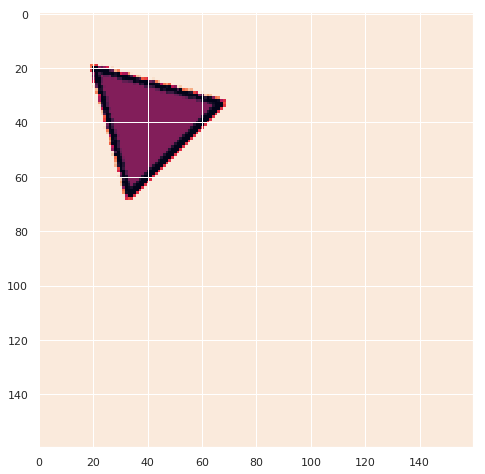

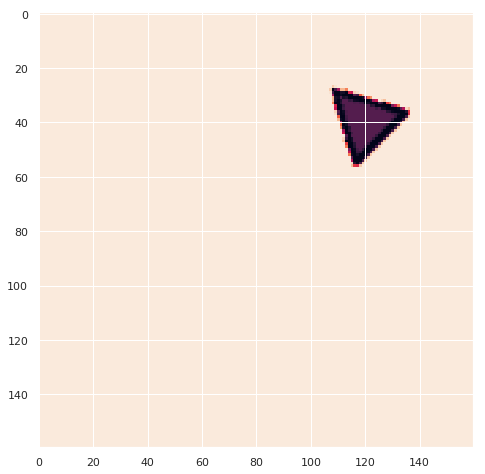

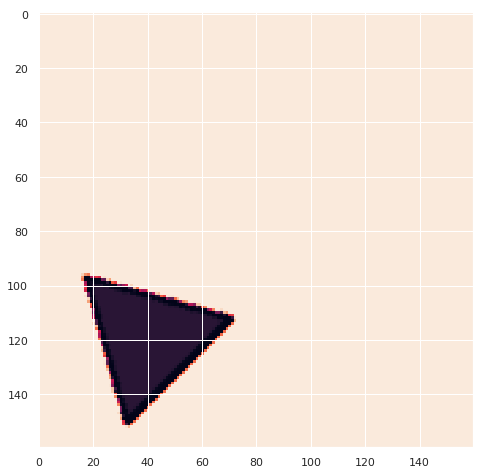

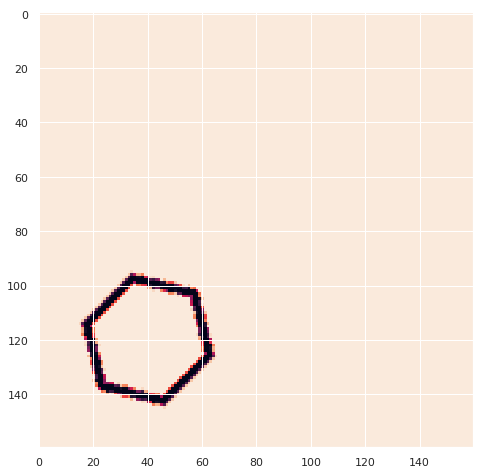

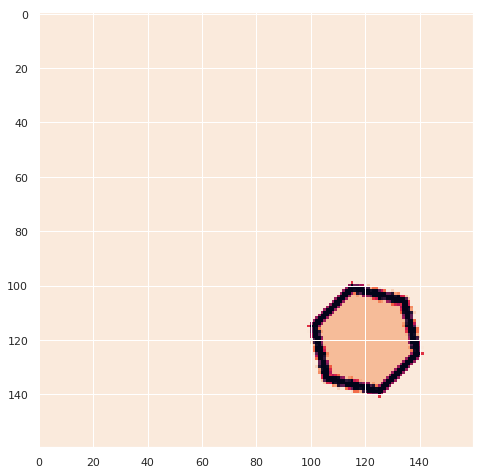

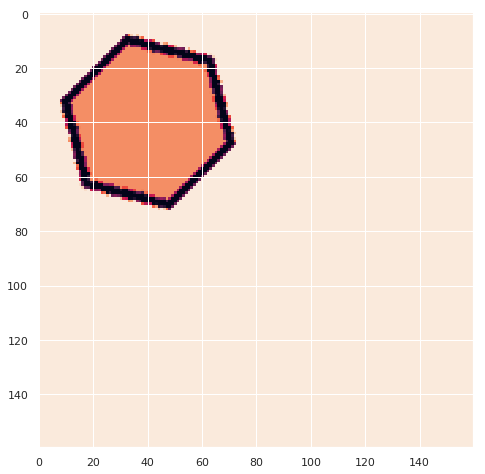

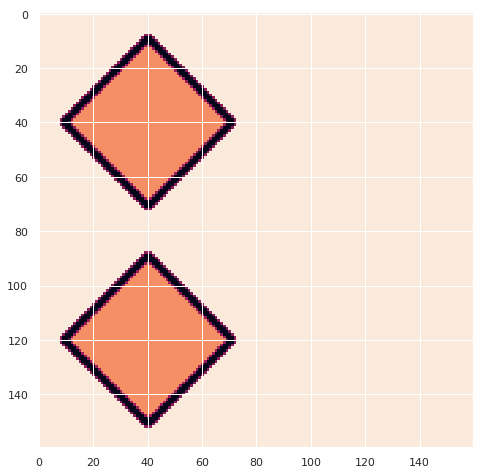

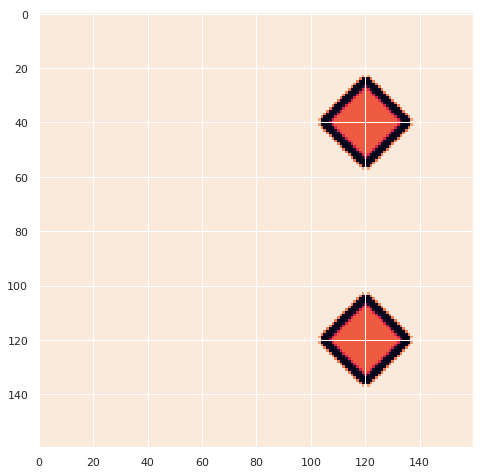

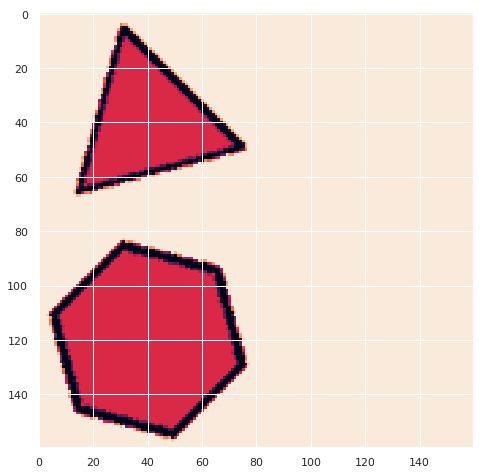

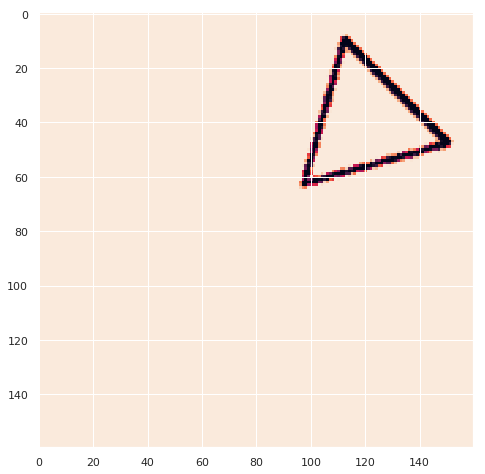

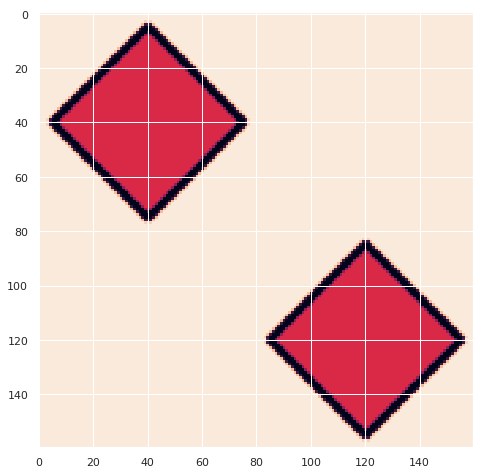

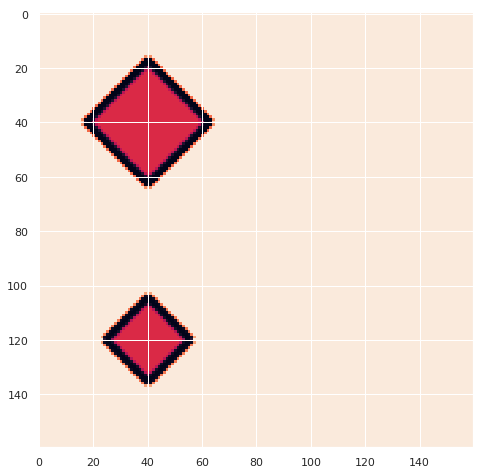

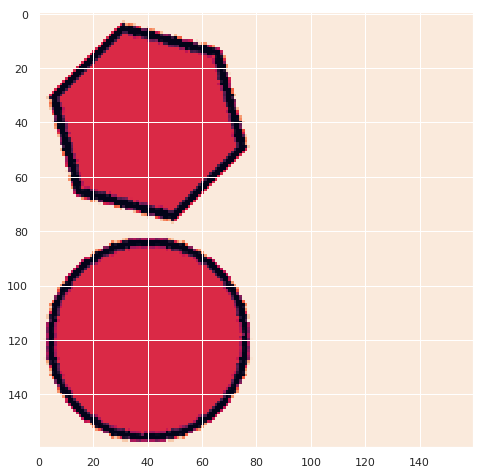

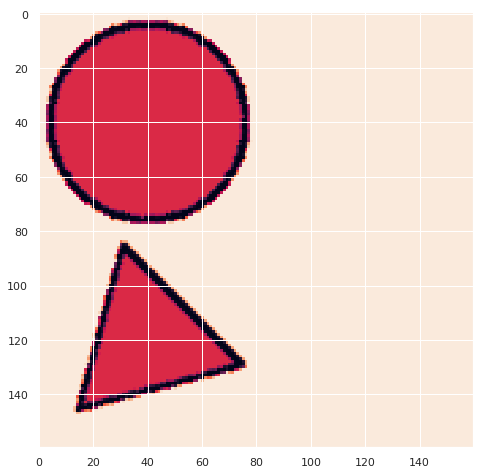

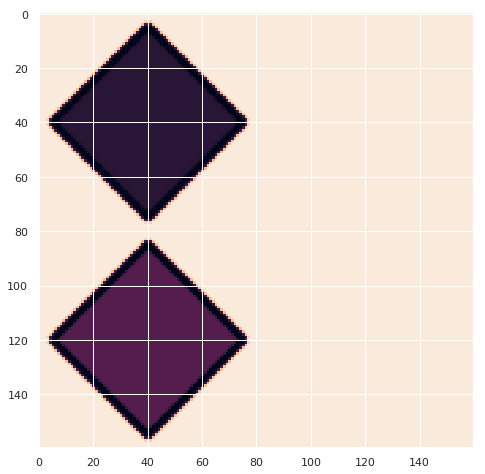

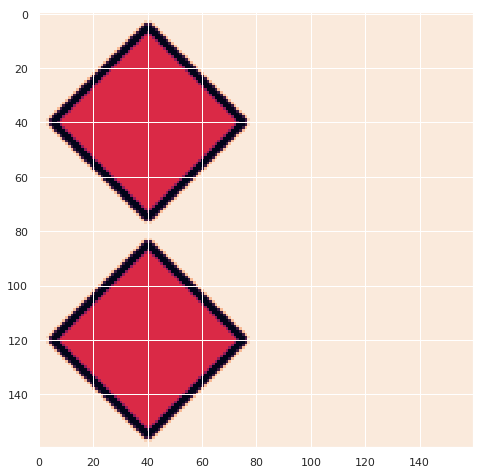

In [186]:
for i in range(16):
#     plt.ion()
    plt.figure()
    plt.imshow(a['image'][i])
